# Quick start into numerical differentiation using algebraic differentiators

Algebraic differentiators are linear time-invariant filters with a finite-duration impulse response. These filters can be approximated as lowpass filters with a known cutoff frequency and a known stopband slope. They depend on 5 parameters: 
* the filter window length $T$
* the powers of the weight function of Jacobi polynomials $\alpha$ and $\beta$
* the truncation order of the generalized Fourier series $N$
* a delay parameter $\vartheta$.

The effects of the parameters can be very briefly summarized as follows (see the second notebook for a detailed discussion):
* Increasing $T$ decreases the effect of measurement disturbances but increases the error from the generalized Fourier series truncation. The filter window length $T$ can be computed from a desired cutoff frequency.
* Increasing $N$ decreases the error from the truncation of the generalized Fourier series expansion but increases the effect of measurement disturbances. A delay-free estimation is only possible for $N>0$. The accuracy is however decreased when the estimate is delay-free.
* The parameters $\alpha$ and $\beta$ have to satisfy $\alpha,\beta>n-1$, with $n$ the highest derivative order to be estimated. 
* In most applications, $\alpha=\beta$ is a good starting point. For large frequencies compared to the cutoff frequency, the signals are attenuated by $20\mu$ dB per decade, with $\mu=\min\{\alpha,\beta\}+1$. For small window lengths, $\alpha$ and $\beta$ have to be chosen large to avoid any discretization effects. Always compare the amplitude spectrum of the continuous-time and discrete-time filters!

In the following example, the first derivative of a signal is estimated.



In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from algebraicDifferentiator import AlgebraicDifferentiator
import numpy as np
import sympy as sp

################################################################
# Define signal x and its measurement y=x+eta with eta 
# a random disturbance
################################################################
# Define sampling rate 
ts = 0.001

# Define signal and its derivatives
a = sp.symbols('a_0:3')
t = sp.symbols('t')
x = a[0]*sp.exp(-a[1]*t)*sp.sin(a[2]*t)

# Derivative to be estimated
dx = sp.diff(a[0]*sp.exp(-a[1]*t)*sp.sin(a[2]*t),t,1)
d2x = sp.diff(a[0]*sp.exp(-a[1]*t)*sp.sin(a[2]*t),t,2)
aeval = {'a_0':1,'a_1':0.1,'a_2':4}

# Evaluate signal and true derivative
teval = np.arange(0,20,ts)
for ai in a:
    x = x.subs({ai:aeval[repr(ai)]})
    dx = dx.subs({ai:aeval[repr(ai)]})
    d2x = d2x.subs({ai:aeval[repr(ai)]})
    
xeval = sp.lambdify(t, x, "numpy")
xeval = xeval(teval)
dxeval = sp.lambdify(t, dx, "numpy")
dxeval = dxeval(teval)
d2xeval = sp.lambdify(t, d2x, "numpy")
d2xeval = d2xeval(teval)

# Get measurement
eta = np.random.normal(0,0.01,len(xeval))
y = xeval + eta

The differentiator has the parameters:
Alpha: 2.000000
Beta: 2.000000
Window length in s: 0.075000
Polynomial degree: 1
Estimation delay in s: 0.023326
Cutoff Frequency: 80.337473
Discrete window length: 75
The differentiator has the parameters:
Alpha: 1.100000
Beta: 1.100000
Window length in s: 0.057000
Polynomial degree: 1
Estimation delay in s: 0.016002
Cutoff Frequency: 80.178896
Discrete window length: 57


<IPython.core.display.Javascript object>


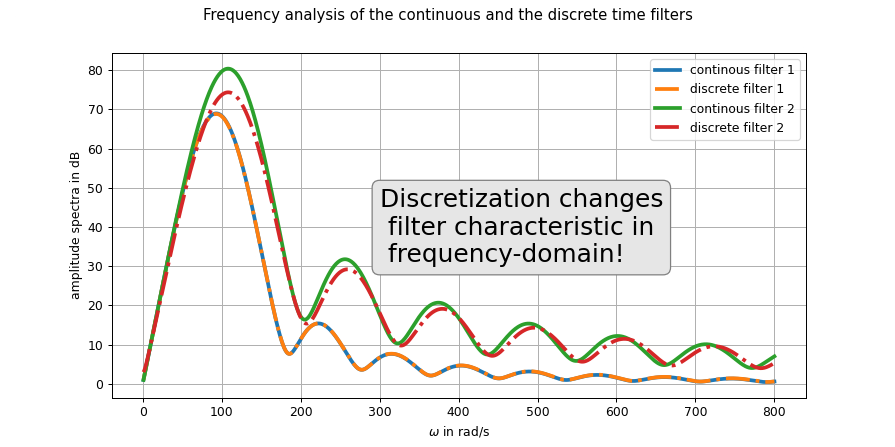

<IPython.core.display.Javascript object>


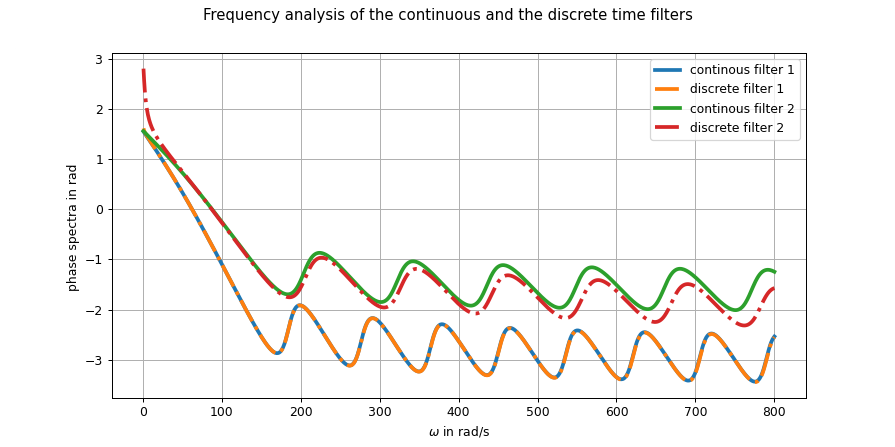

In [7]:
################################################################
# Initialize a two differentiators with a desired cutoff 
# frequency with different alpha and beta. See later the effect
# of these parameters after the discretization
################################################################
wc = 80
algDiff1 = AlgebraicDifferentiator(N=1,alpha=2,beta=2,T=None,wc = wc, ts=ts)
algDiff2 = AlgebraicDifferentiator(N=1,alpha=1.1,beta=1.1,T=None,wc = wc, ts=ts)

# Discretization method
method = "trapezoidal"

# For a delay-free approximation uncomment the followning lines
# Note: A delay-free approximation is less accurate and less
# robust with respect to disturbances
# algDiff1.set_theta(1,False)
# algDiff1.set_theta(1,False)

################################################################
# Frequency-domain analysis
################################################################
omega = np.linspace(1,800,10**3)

# Get phase and amplitude of Fourier transform of the continous 
# and discrete time filter for the estimation of the first
# derivative.
# Note: get_ampAndPhaseFilter return the Fourier transform of
# the continuous-time kernel. To compute the filter for the
# n-th derivative multiply with (j\omega)^n, with j the imaginary unit. 
# The function get_ampSpectrumDiscreteFilter returns the amplitude
# of the discrete-time filter for the specified derivative order.

ampCont1,phaseCont1 = algDiff1.get_ampAndPhaseFilter(omega)
ampCont1 = ampCont1*(1j*omega)
phaseCont1 = phaseCont1 + np.angle((1j*omega))
ampDiscrete1,phaseDis1 = algDiff1.get_ampSpectrumDiscreteFilter(omega,1,method=method)

ampCont2,phaseCont2 = algDiff2.get_ampAndPhaseFilter(omega)
ampCont2 = ampCont2*(1j*omega)
phaseCont2 = phaseCont2 + np.angle((1j*omega))
ampDiscrete2,phaseDis2 = algDiff2.get_ampSpectrumDiscreteFilter(omega,1,method=method)

# Plot results
fig, ax = plt.subplots(nrows=1, ncols=1,sharex=False, figsize=(10, 5))
l = 3
fig.suptitle("Frequency analysis of the continuous and the discrete time filters")
ax.plot(omega,abs(ampCont1),label='continous filter 1',linewidth=l)
ax.plot(omega,ampDiscrete1,'-.',label='discrete filter 1',linewidth=l)
ax.plot(omega,abs(ampCont2),label='continous filter 2',linewidth=l)
ax.plot(omega,ampDiscrete2,'-.',label='discrete filter 2',linewidth=l)
ax.set_xlabel(r"$\omega$ in rad/s")
ax.set_ylabel(r"amplitude spectra in dB")
ax.legend()
ax.grid()
plt.text(300, 50, "Discretization changes\n filter characteristic in\n frequency-domain!", size=20, va="top",
         bbox=dict(boxstyle="round",
                   ec=(0.5, 0.5, 0.5),
                   fc=(0.9, 0.9, 0.9),
                   )
         )
fig.show()

fig, ax = plt.subplots(nrows=1, ncols=1,sharex=False, figsize=(10, 5))
l = 3
fig.suptitle("Frequency analysis of the continuous and the discrete time filters")
ax.plot(omega,phaseCont1,label='continous filter 1',linewidth=l)
ax.plot(omega,phaseDis1,'-.',label='discrete filter 1',linewidth=l)
ax.plot(omega,phaseCont2,label='continous filter 2',linewidth=l)
ax.plot(omega,phaseDis2,'-.',label='discrete filter 2',linewidth=l)
ax.set_xlabel(r"$\omega$ in rad/s")
ax.set_ylabel(r"phase spectra in rad ")
ax.legend()
ax.grid()
plt.text(300, 50, "Discretization changes\n filter characteristic in\n frequency-domain!", size=20, va="top",
         bbox=dict(boxstyle="round",
                   ec=(0.5, 0.5, 0.5),
                   fc=(0.9, 0.9, 0.9),
                   )
         )
fig.show()


################################################################
# Estimate derivatives
################################################################
# Estimate 0-th derivative
xApp = algDiff1.estimateDer(0,y,method=method)
# Estimate first derivative
dxApp = algDiff1.estimateDer(1,y,method=method)




<IPython.core.display.Javascript object>


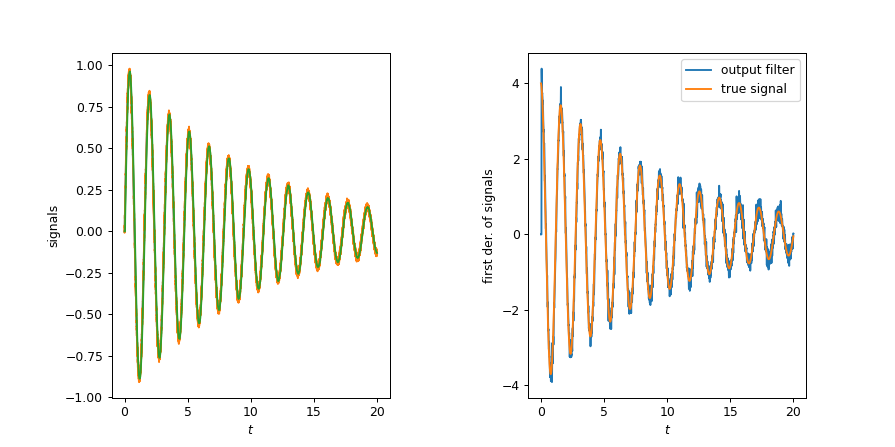

In [3]:
################################################################
# Plot results
################################################################
fig, (fy,fdy) = plt.subplots(nrows=1, ncols=2,sharex=True, figsize=(10, 5))
fig.subplots_adjust( wspace=0.5)
fy.plot(teval,xeval,label='x')
fy.plot(teval,y,label='y')
fy.plot(teval,xApp,label='output filter')
fy.set_xlabel(r'$t$')
fy.set_ylabel(r'signals')

fdy.plot(teval,dxApp,label='output filter')
fdy.plot(teval,dxeval,label='true signal')
fdy.set_xlabel(r'$t$')
fdy.set_ylabel(r'first der. of signals')

plt.legend()

plt.show()

In [4]:
################################################################
# Saving filer coefficients for the estimation of the first
# derivative using the discretization method specified above
################################################################
coeff = algDiff1.discretize(1,method) 
c = coeff[1][method]